# Project Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Statistical libraries
from scipy.stats import norm, chi2_contingency

# ML Models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib as jl
from sklearn.inspection import permutation_importance

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"
MODELS = "./models/"

# Flags
process = False

# Replace files
write_2_disk = False

# Seed for reproducibility
seed = 7

# Set the style for plots}
sns.set_style("whitegrid")

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    transfermarkt = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    fifa22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    fifas21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(fifas21.sofifa_id).difference(set(fifa22.sofifa_id))
    FIFA = pd.concat([fifa22, fifas21[fifas21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    transfermarkt.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(transfermarkt, FIFA)
    # Append the extracted FIFA long names
    transfermarkt["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    transfermarkt["fifa_id"] = transfermarkt["FIFA_long_name"] + "-" + pd.to_datetime(transfermarkt["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = transfermarkt.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# II. Methods

## A. Histograms, Kernel Density Estimation and Chi-Square Goodnes-of-Fit Test

### Players' age distribution: Histogram and KDE vs. Normal Distribution plot
We can also plot the histogram of all players' age in the Transfermarkt dataset, to get a sense of the age distribution across players.

### Jacknife for Mean and Age Range

In [4]:
age_distribution = players['age'].value_counts()
data = []
for age, count in age_distribution.items():
    data.extend([age] * count)

### calculating the mean of the population
initial_statistic = np.mean(data)

jackknife_samples = [round(np.mean([age for age in data if age != left_out_age]), 5) 
                     for left_out_age in set(data)]


n = len(set(data))  # Number of unique ages
mean_jackknife_samples = np.mean(jackknife_samples)
variance = (n - 1) / n * np.sum((jackknife_samples - mean_jackknife_samples) ** 2)
standard_error = np.sqrt(variance)
ci_lower = initial_statistic - 1.96 * standard_error
ci_upper = initial_statistic + 1.96 * standard_error


age_distribution = players['age'].value_counts().sort_index()

# Calculating mean, CI, and standard deviation
mean_age = np.mean(players['age'])
std_dev_age = np.std(players['age'])

print('Mean is:', mean_age, ";",'Confidence interval for the mean is:', ci_lower, ci_upper)

Mean is: 25.67452280670311 ; Confidence interval for the mean is: 23.75965347886791 27.589392134538308


In [5]:
### Jacknife for age ranges
initial_range = np.max(data) - np.min(data)
n = len(data)

# Create jackknife samples and calculate their ranges
jackknife_ranges = [np.max(np.delete(data, i)) - np.min(np.delete(data, i)) for i in range(n)]

# Calculate variance and standard error of these ranges
var_estimate = (n - 1) / n * np.sum((jackknife_ranges - initial_range) ** 2)
std_error = np.sqrt(var_estimate)

# Calculate the 95% confidence interval
ci_lower = initial_range - 1.96 * std_error
ci_upper = initial_range + 1.96 * std_error

print(f"95% Confidence Interval for the age range: [{ci_lower}, {ci_upper}]")

95% Confidence Interval for the age range: [25.04008782345697, 28.95991217654303]


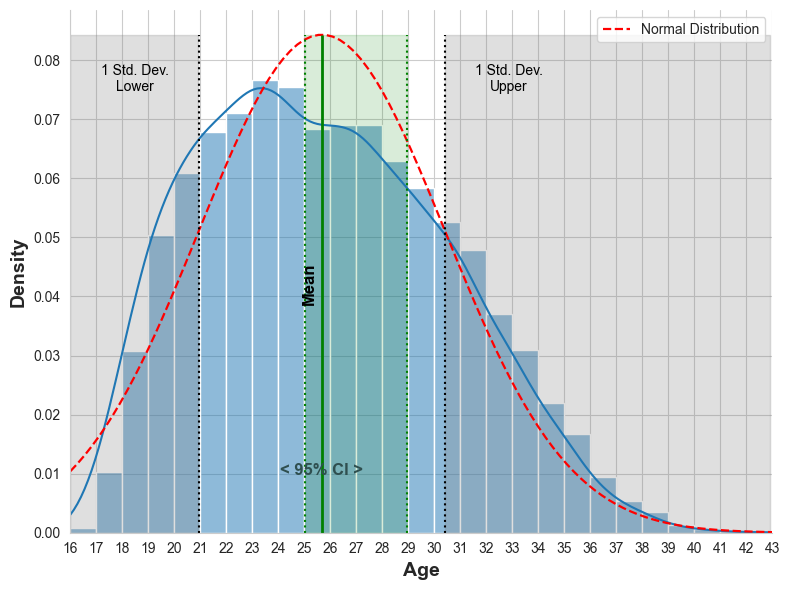

In [6]:
# Plot results
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 12

# Plot the histogram of ages
sns.histplot(data=players, x="age", kde=True, stat="density", bins=np.arange(players.age.min(), players.age.max() + 1), ax=ax)

# Fit a normal distribution to the data
mu, std = np.mean(players.age), np.std(players.age)
xmin, xmax = plt.xlim(players.age.min(), players.age.max())
plt.xticks(players.age.unique())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--r', linewidth=1.6, label='Normal Distribution')

ylim = max(p)

# Add mean and CI
ax.vlines(x=mean_age, ymin=0, ymax=ylim, color='green', linestyle='-', linewidth=2)
ax.vlines(x=ci_lower, ymin=0, ymax=ylim, color='green', linestyle=':')
ax.vlines(x=ci_upper, ymin=0, ymax=ylim, color='green', linestyle=':')
ax.fill_between(np.arange(ci_lower, ci_upper, 0.1), ylim, y2=0, color="green", alpha=0.15)
ax.text(mean_age-0.5, ylim/2, 'Mean', rotation='vertical', ha='center', va='center', fontsize=12, color='black', weight="bold")
ax.text(mean_age, ylim/8, '< 95% CI >', rotation='horizontal', ha='center', va='center', fontsize=12, color='darkslategray', weight="bold")

# Add standard deviation
ax.vlines(x=mean_age - std_dev_age, ymin=0, ymax=ylim, color='black', linestyle=':')
ax.vlines(x=mean_age + std_dev_age, ymin=0, ymax=ylim, color='black', linestyle=':')
ax.fill_between(np.arange(plt.xlim()[0], mean_age - std_dev_age, 0.1), ylim, y2=0, color="grey", alpha=0.25)
ax.fill_between(np.arange(mean_age + std_dev_age, plt.xlim()[1], 0.1), ylim, y2=0, color="grey", alpha=0.25)
ax.text(plt.xlim()[0] + (mean_age - std_dev_age - plt.xlim()[0])/2, ylim-0.01, '1 Std. Dev.\nLower', rotation='horizontal', ha='center', va='bottom', fontsize=10, color='black')
ax.text(mean_age + std_dev_age + (mean_age - std_dev_age - plt.xlim()[0])/2, ylim-0.01, '1 Std. Dev.\nUpper', rotation='horizontal', ha='center', va='bottom', fontsize=10, color='black')

# Add labels
plt.xlabel('Age', fontsize=14, weight="bold")
plt.ylabel('Density', fontsize=14, weight="bold")
plt.legend()
plt.tight_layout()

sns.despine(ax=ax, top=True, right=True)
# Show the plot
plt.show()

### Chi-Square Goodnes-of-Fit Test

The data appears roughly normally distributed, with a slight right tail. To test for a normal distribution fit, we use a Chi-square goodness of fit test, with an alpha level of 0.05. The chi-square test (Snedecor and Cochran, 1989) is used to test if a sample of data came from a population with a specific distribution. <br>
$H_0$:	The data follow a specified distribution (i.e., Normal). <br>
$H_a$:	The data do not follow the specified distribution.


In [7]:
# Select an alpha level
alpha = 0.05

# Total observations
N = players.shape[0]

# Parameters for the normal distribution (mean and standard deviation)
mean_age = np.mean(players.age)
std_age = np.std(players.age)

# Range of ages
ages = pd.Series(np.arange(players.age.min(), players.age.max()+1))

# Calculate the probability function for each age
expected_frequencies = N * norm.pdf(ages, loc=players.age.mean(), scale=players.age.std())

# Get the observed frequencies
observed_frequencies = players.groupby("age").size()

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency([observed_frequencies, expected_frequencies])

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

if p_value < alpha:
    print("We reject the null hypothesis, and thus conclude the distribution is not normal.")
else:
    print("We cannot reject the null hypothesis, and thus it can be possible that the distribution is normal.")

Chi-squared Statistic: 330.2726147151785
P-value: 6.398325123547772e-54
Degrees of Freedom: 27
We reject the null hypothesis, and thus conclude the distribution is not normal.


## B. Survival Analysis
The first step is to recognize retired players. We apply the assumption that a player is retired if he hasn't played for over a year, has no current club, no market value and no contract.

In [8]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)

# Use custom function generate boolean flag for "Retired" players
players = detect_retired(players)

# A glance to the retire players
players[players.retired].head()

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True


Now are all players in the dataset contain a "retired" flag.

### 1. Hazard rate, Activity Rate and Kapler-Meier Estimate

#### FOOTBALL PLAYERS PROFESSIONAL LIFE TABLE
Similar to the life tables in traditional Survival Analysis, the "professional life" table will compute the probability of retiring ('h') at a given age (based on their frequency), and a "Activity" ('A') probability at a given age, computed as the probability of NOT being retired at that age.

In [9]:
if process:
    professional_life_table = get_retire_table(players, ci=(0.025, 0.975), bootstrap_settings={"simulations": 10000})
    professional_life_table.to_csv(PROC_DATA + "professional_life_table.csv", encoding="utf-8", index=False)
else:
    professional_life_table = pd.read_csv(PROC_DATA + "professional_life_table.csv")

In [10]:
professional_life_table

,age,n,retired,h,A,0.025,0.975,e
0,16,9,0,0.000000,1.000000,1.000000,1.000000,21.014007
1,17,115,0,0.000000,1.000000,1.000000,1.000000,20.014007
2,18,344,2,0.005814,0.994186,0.984985,1.000000,19.014007
3,19,562,4,0.007117,0.987110,0.975403,0.996441,18.019821
4,20,680,7,0.010294,0.976949,0.962904,0.988789,17.032711
5,21,757,3,0.003963,0.973077,0.958769,0.985585,16.055763
6,22,793,4,0.005044,0.968169,0.952904,0.981502,15.082686
7,23,855,4,0.004678,0.963639,0.947846,0.977780,14.114517
8,24,843,1,0.001186,0.962496,0.946457,0.976769,13.150878
9,25,763,4,0.005242,0.957450,0.940889,0.972428,12.188382


In [11]:
# TEMP CODE TO WRITE TABLE AS LATEX
"""
dtypes= {k: int for k in professional_life_table.columns[:3]}
dtypes.update({k: float for k in professional_life_table.columns[3:]})
write_latex_table(professional_life_table, dtypes=dtypes)
"""

'\ndtypes= {k: int for k in professional_life_table.columns[:3]}\ndtypes.update({k: float for k in professional_life_table.columns[3:]})\nwrite_latex_table(professional_life_table, dtypes=dtypes)\n'

Let's plot the survival curve with the confidence intervals.

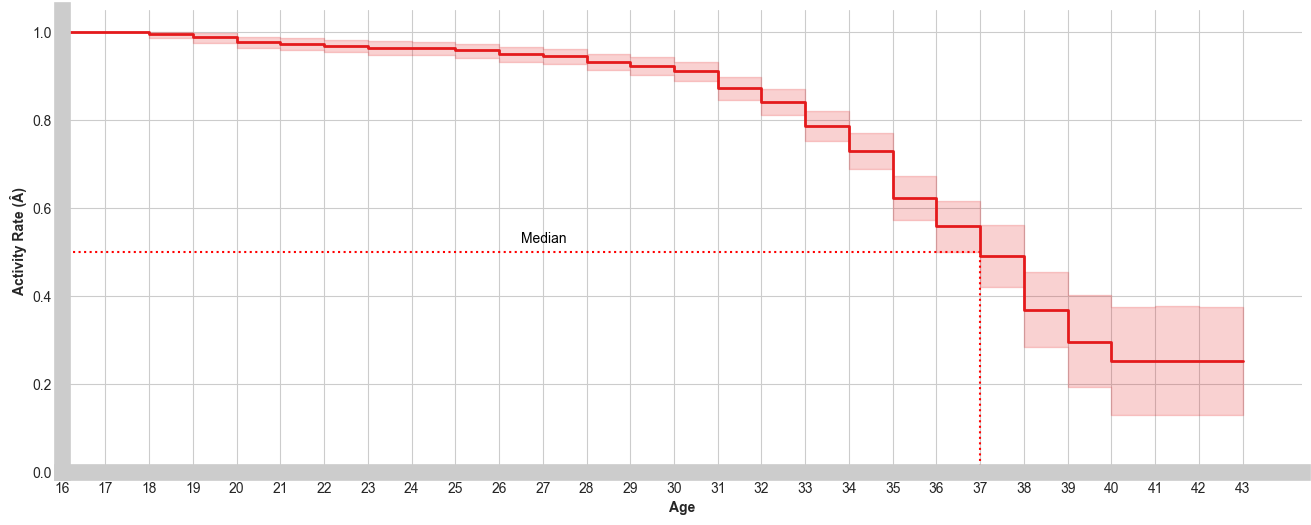

In [12]:
km_curves(professional_life_table, labels=None, ci=True)

### MCMC 


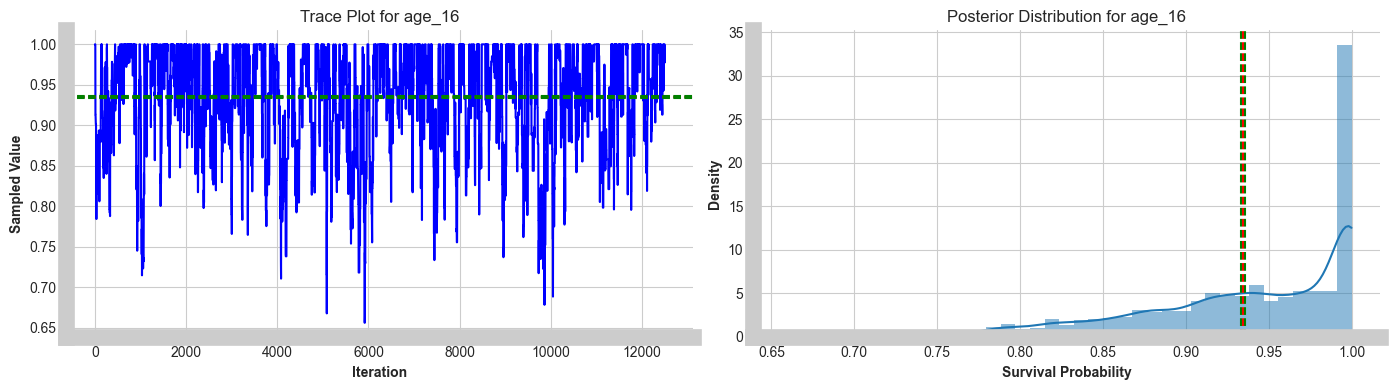

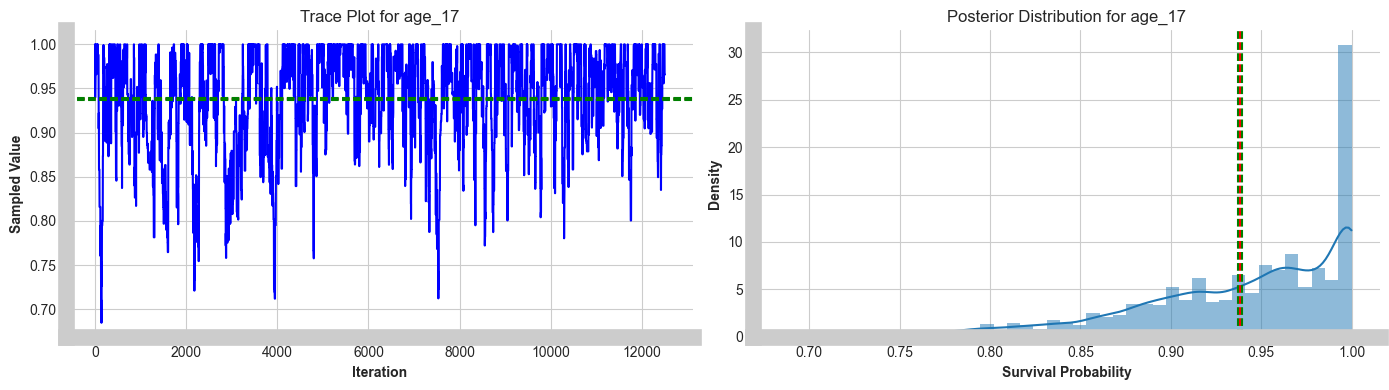

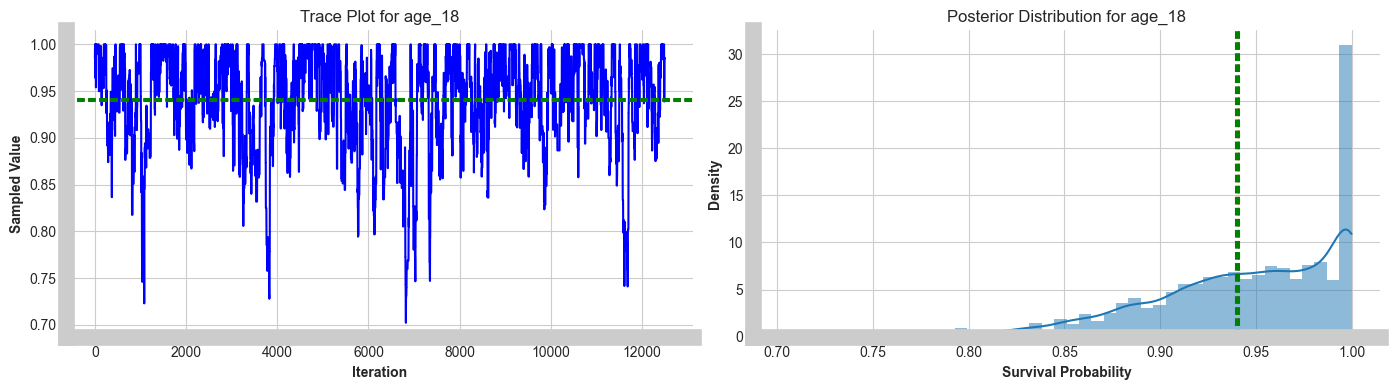

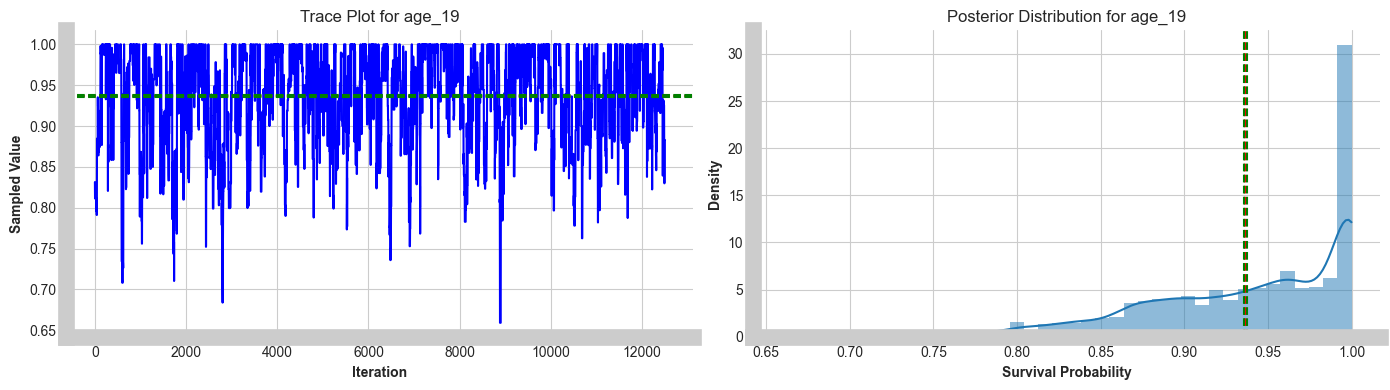

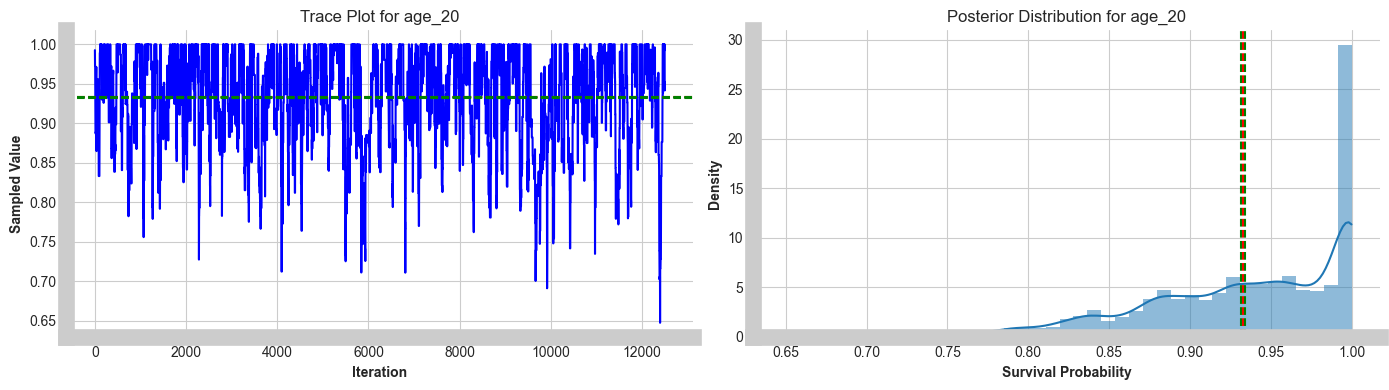

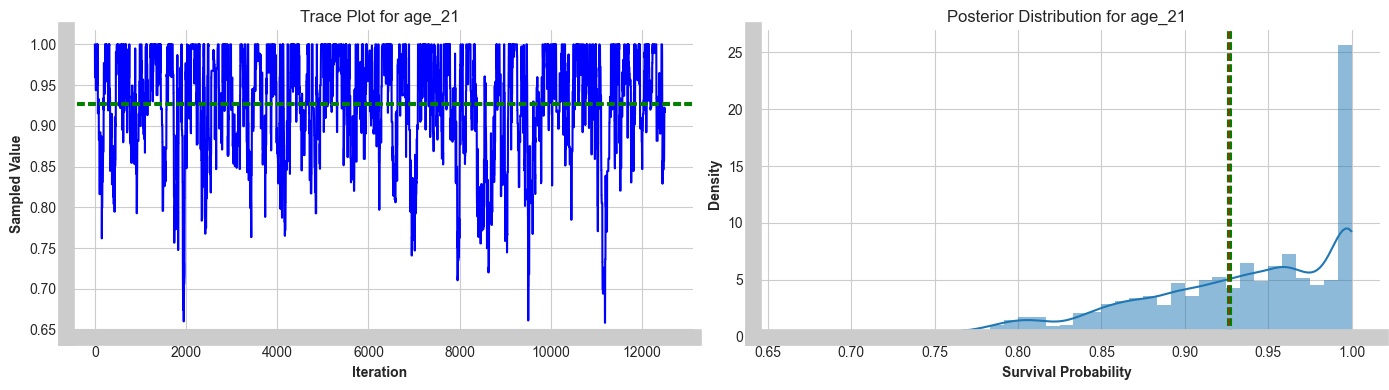

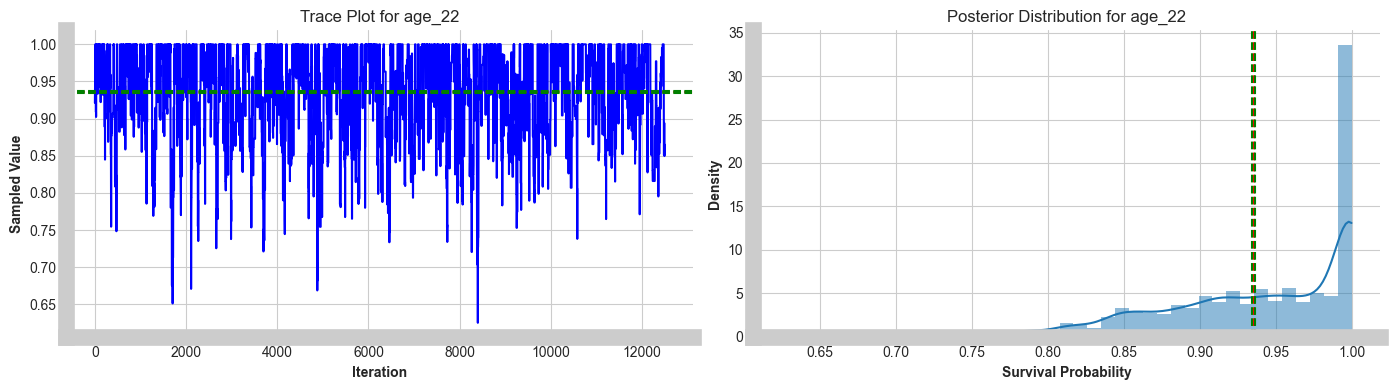

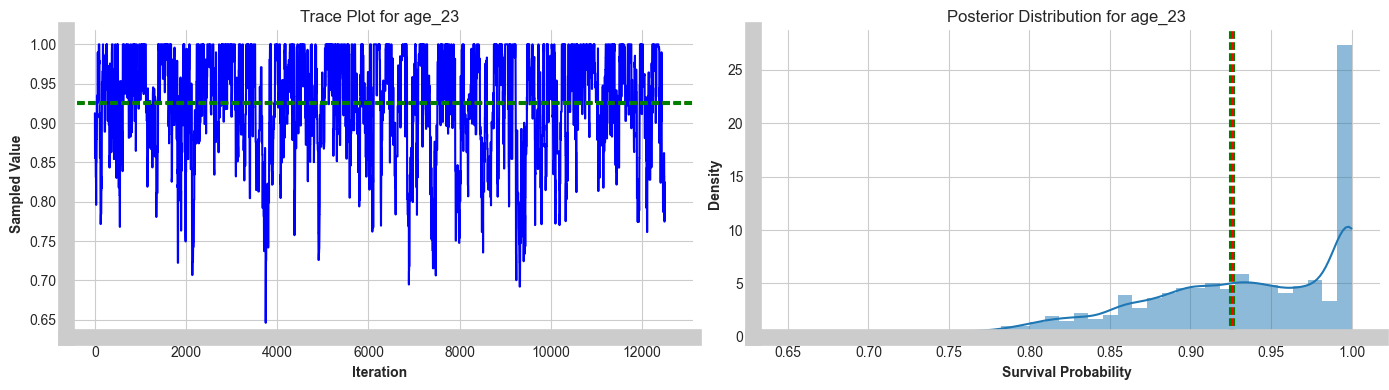

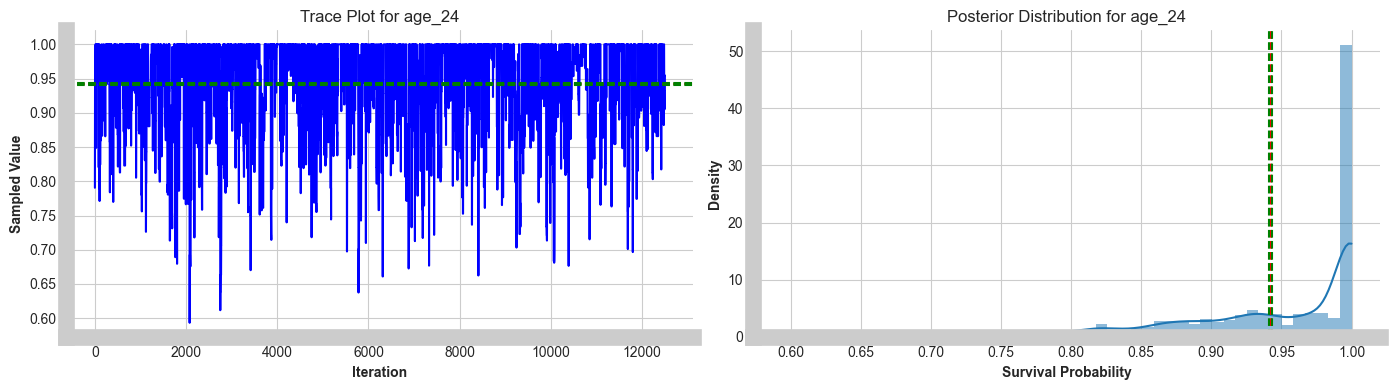

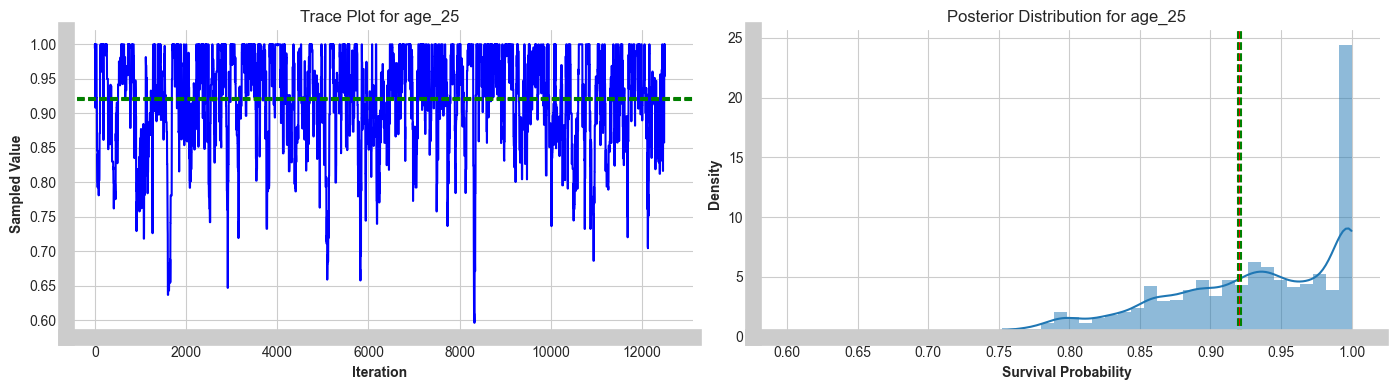

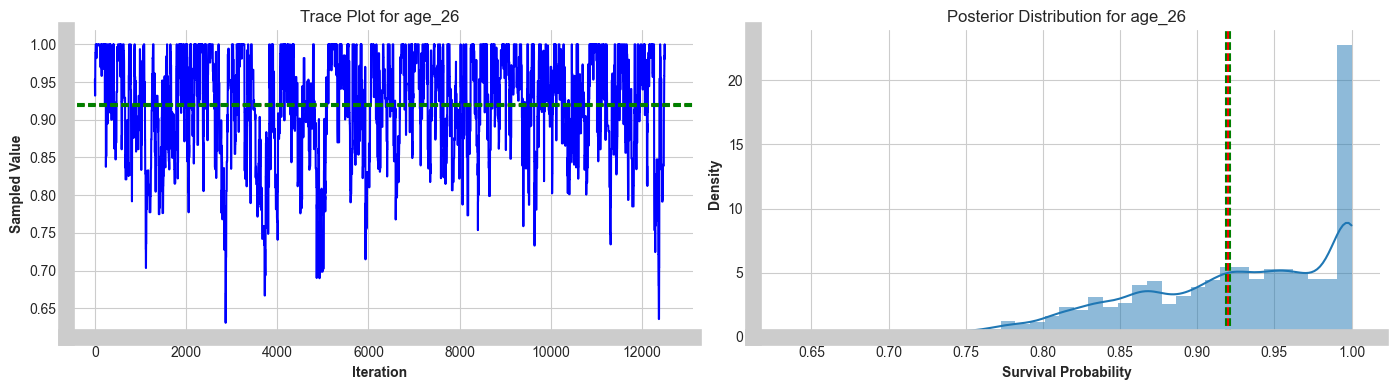

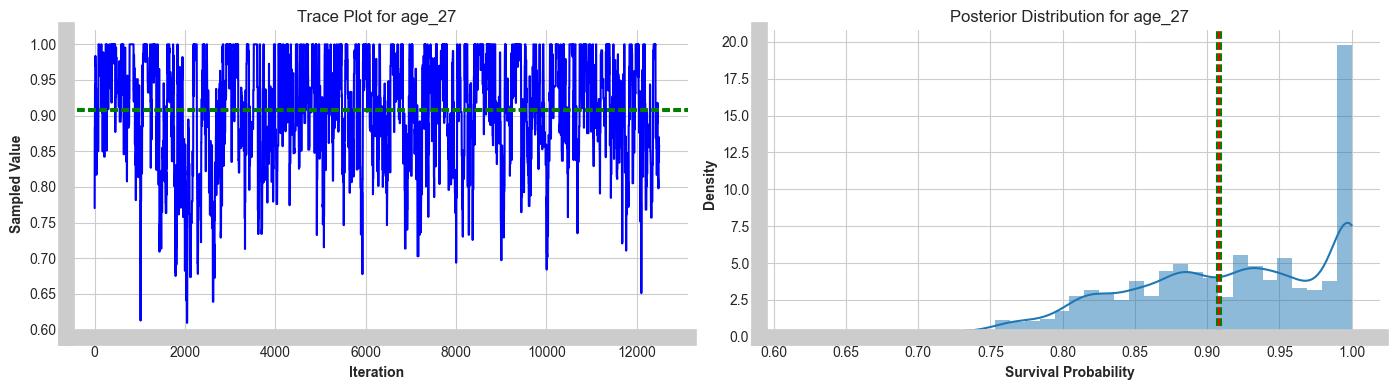

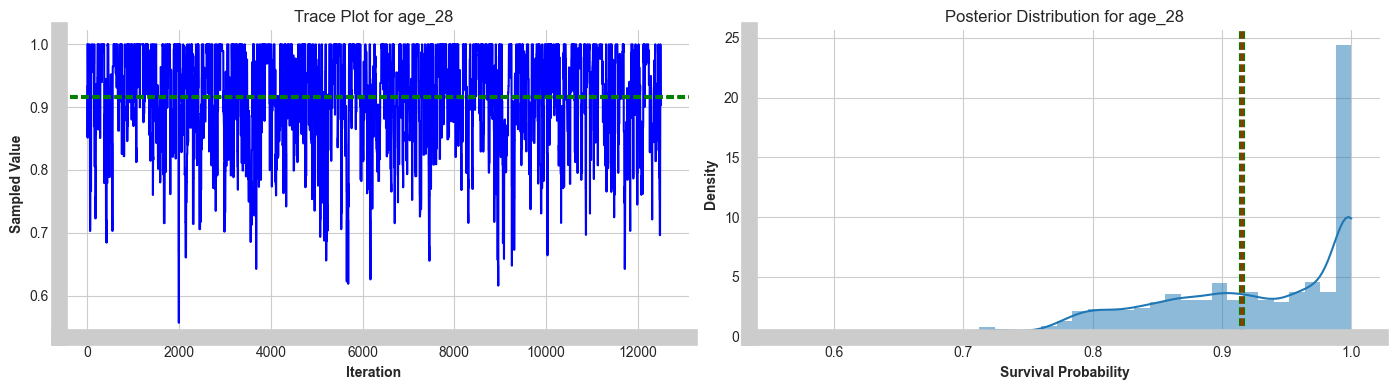

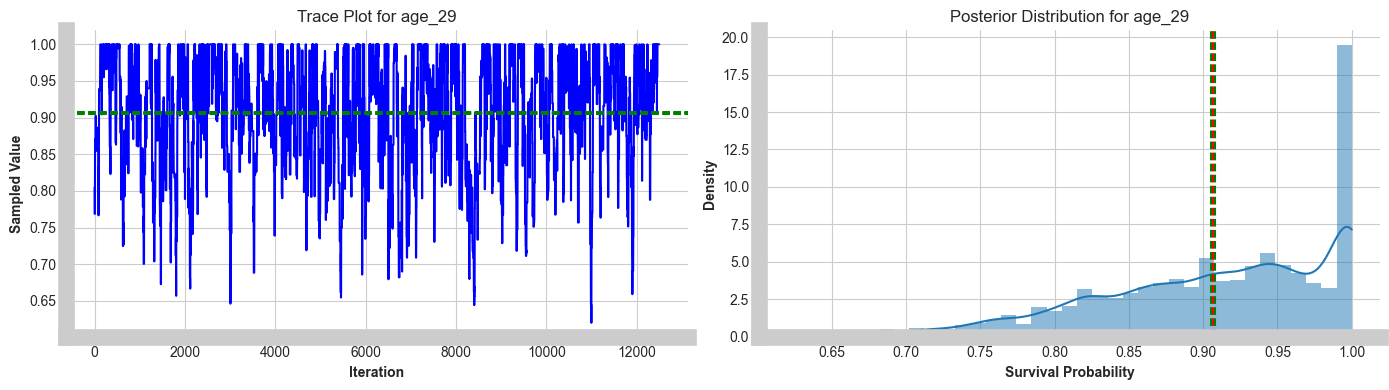

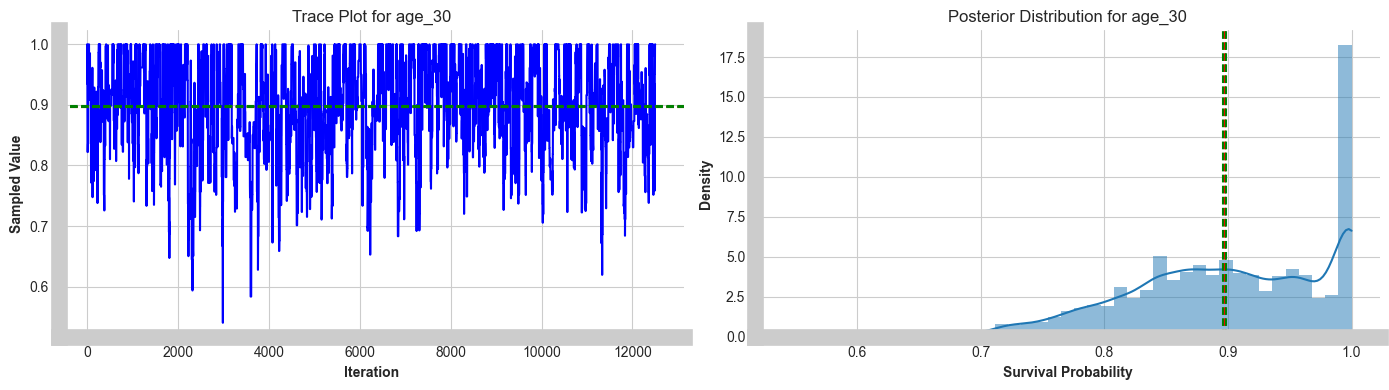

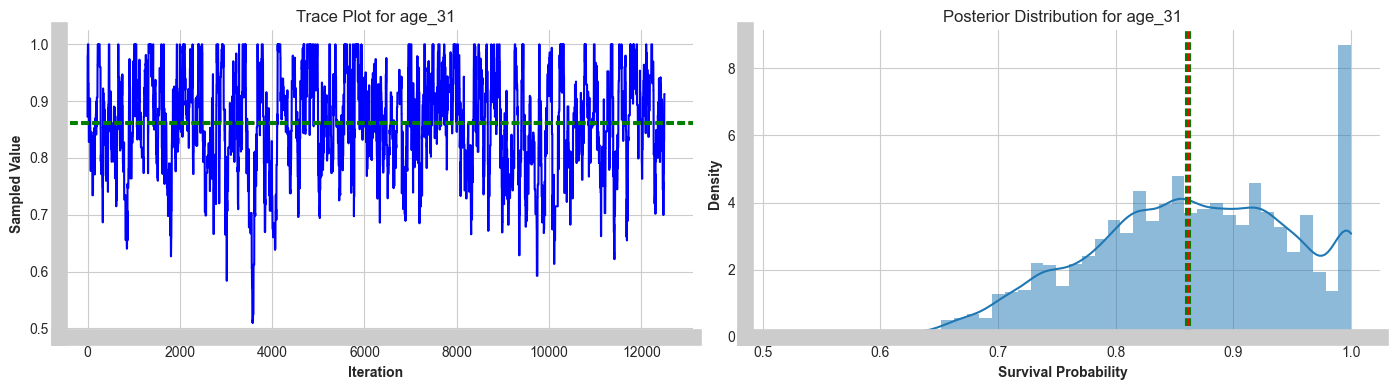

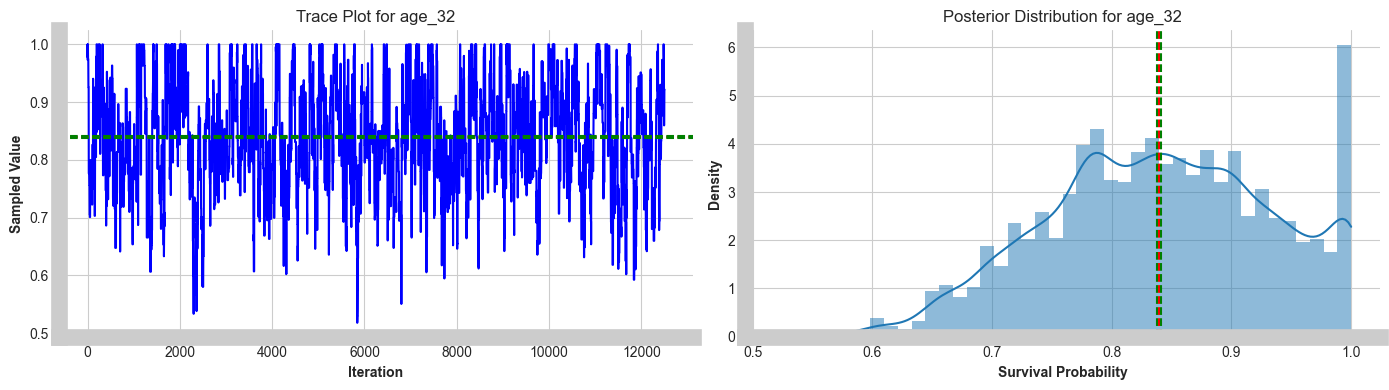

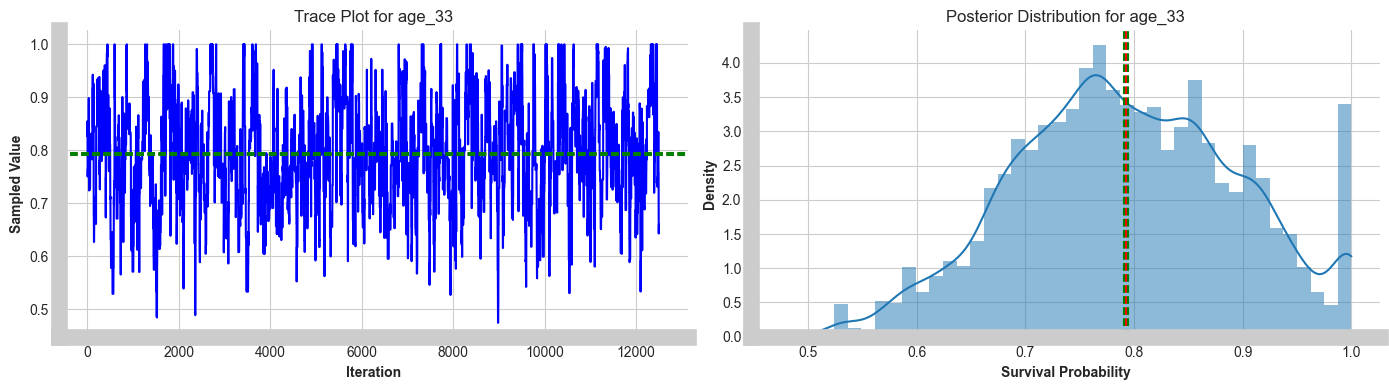

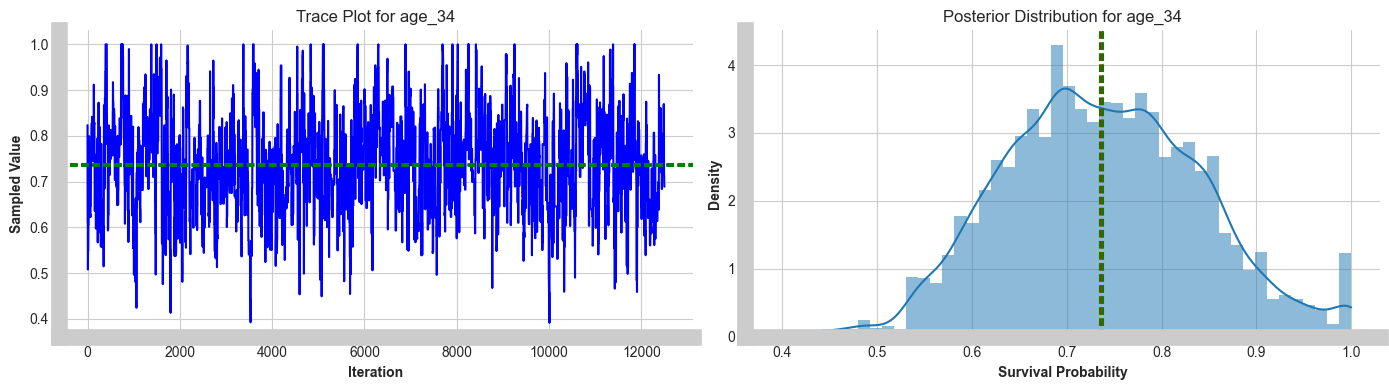

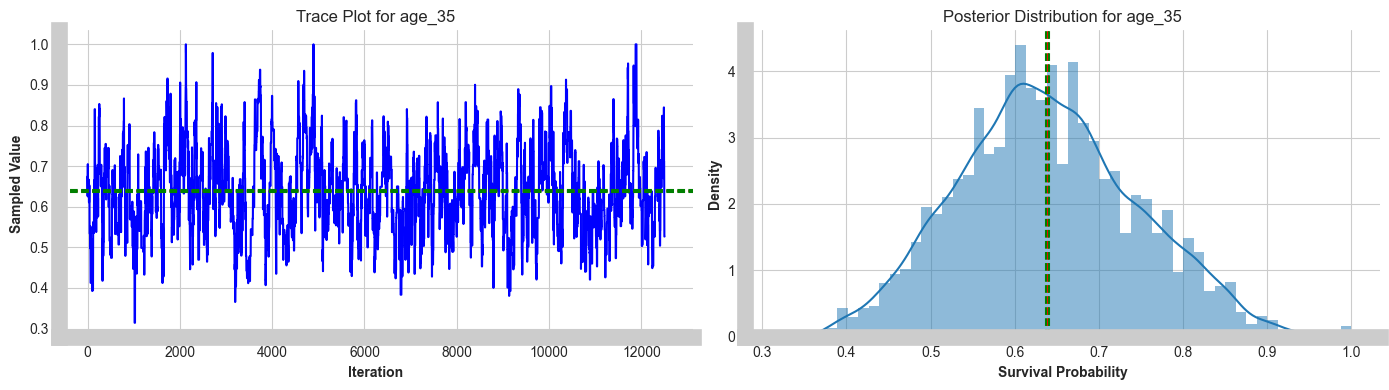

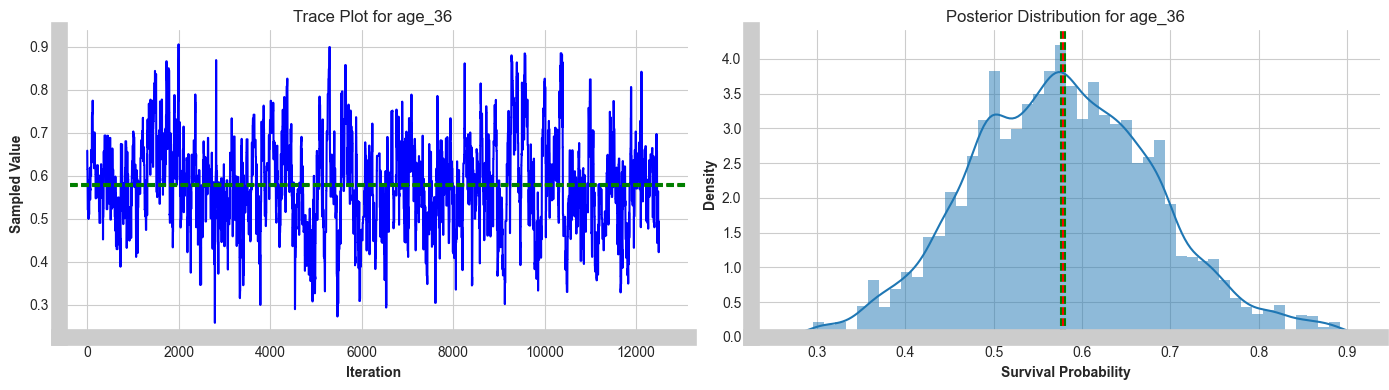

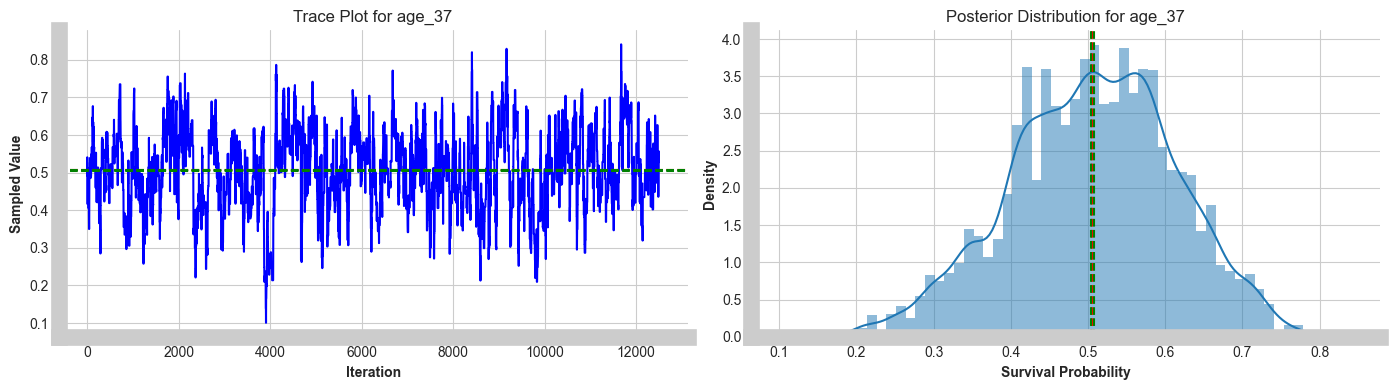

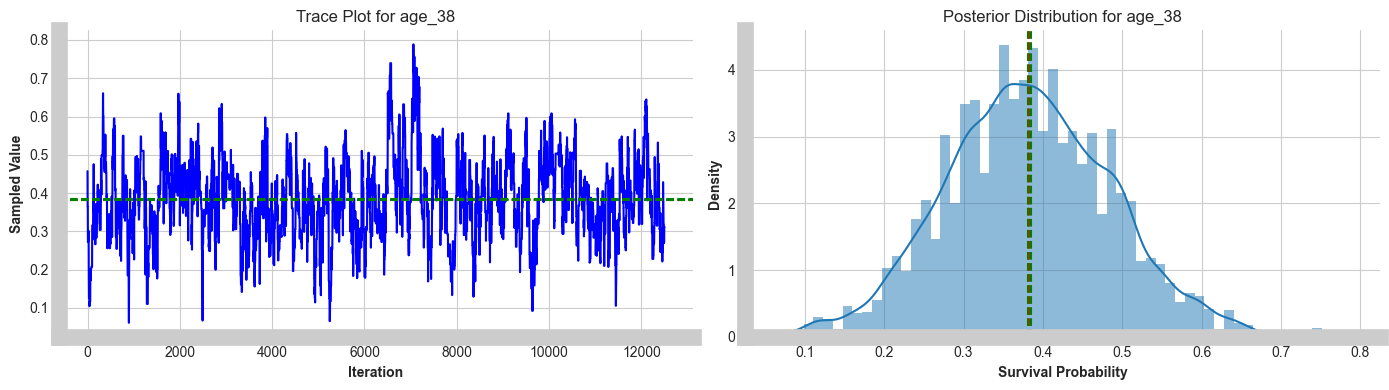

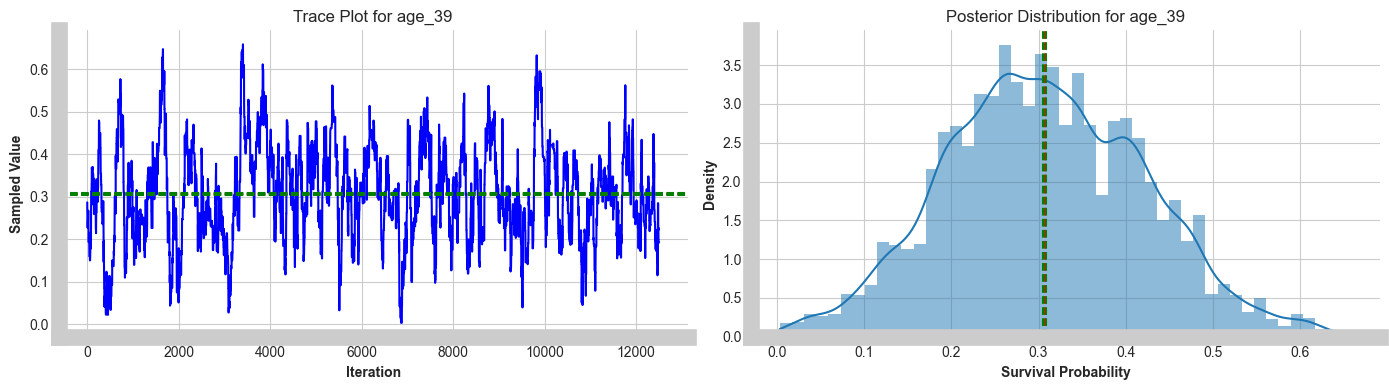

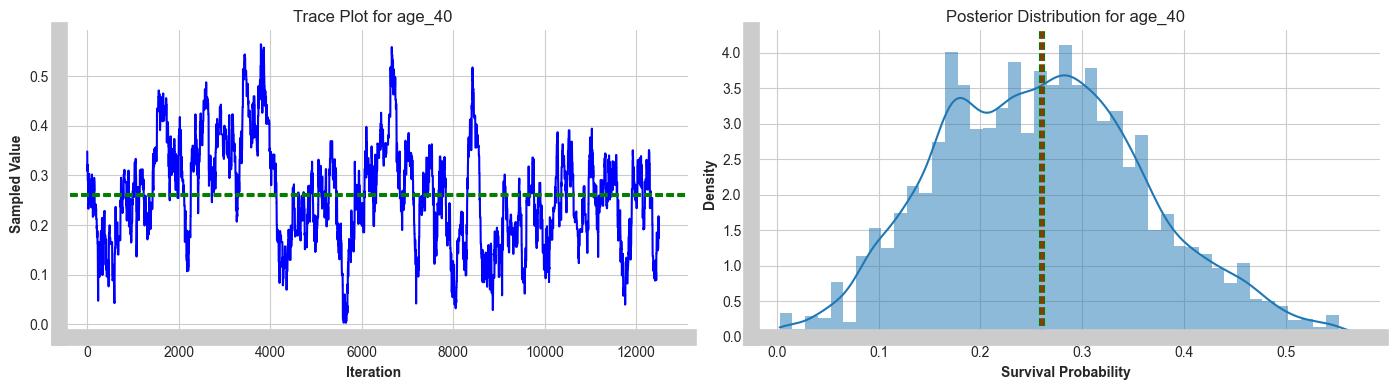

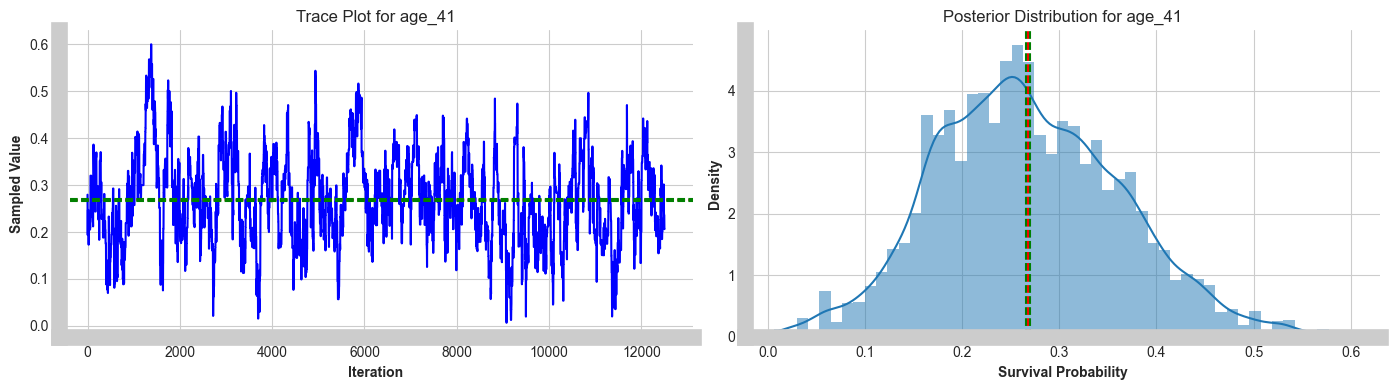

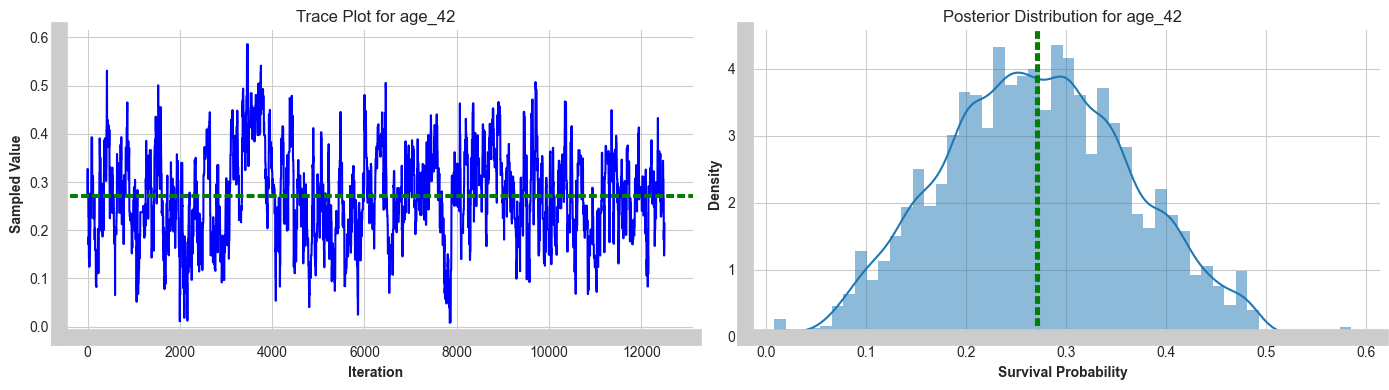

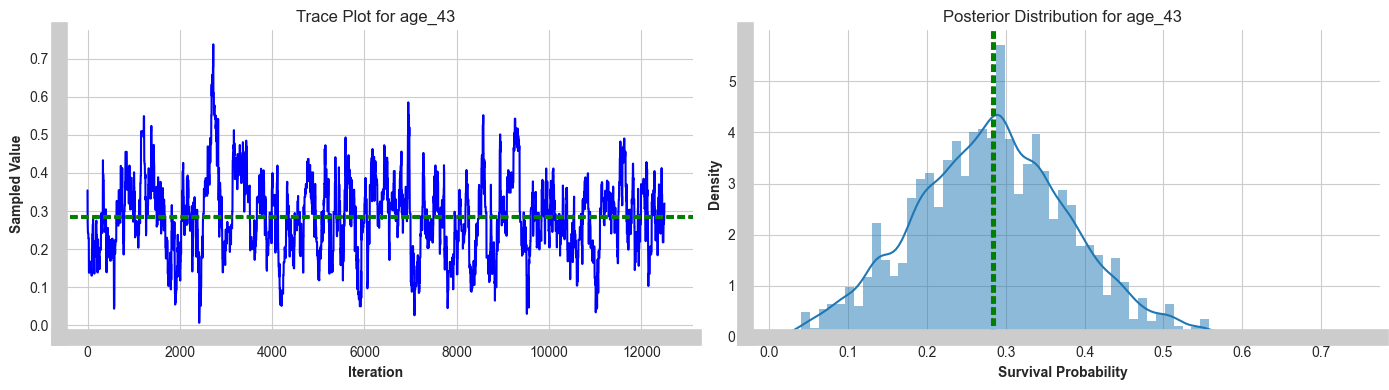

In [14]:
life_table = professional_life_table.copy()
life_table.rename(columns={"A": "survival_prob"}, inplace=True)

mcmc_samples = Weighted_metropolis_mcmc(life_table, 25000, 0.05)

# Creating a DataFrame for analysis
mcmc_df_full = pd.DataFrame(mcmc_samples, columns=[f'age_{age}' for age in life_table['age']])

# Plotting the trace plots and histograms with 95% CI for each parameter
for i, column in enumerate(mcmc_df_full.columns):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    
    # Calculate the mean and 95% CI for the jackknife for the current column
    mean_value, ci = jackknife_ci(mcmc_df_full[column].values)
    
    # Trace plot on the left
    axs[0].plot(mcmc_df_full[column], color='blue')
    axs[0].axhline(mean_value, color='red', linestyle='--')  # Add the mean as a dashed line
    axs[0].axhline(ci[0], color='green', linestyle='--')  # Lower bound of CI
    axs[0].axhline(ci[1], color='green', linestyle='--')  # Upper bound of CI
    axs[0].set_title(f'Trace Plot for {column}')
    axs[0].set_xlabel('Iteration', weight="bold")
    axs[0].set_ylabel('Sampled Value', weight="bold")

    # Histogram (Posterior distribution) on the right
    sns.histplot(mcmc_df_full[column], kde=True, stat="density", linewidth=0, ax=axs[1])
    axs[1].axvline(mean_value, color='red', linestyle='--')  # Mean
    axs[1].axvline(ci[0], color='green', linestyle='--')  # Lower bound of CI
    axs[1].axvline(ci[1], color='green', linestyle='--')  # Upper bound of CI
    axs[1].set_title(f'Posterior Distribution for {column}')
    axs[1].set_xlabel('Survival Probability', weight="bold")
    axs[1].set_ylabel('Density', weight="bold")

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

### 3. KM Curves across different groups

We will test three different grouppings:
* Body Type (3 groups: Lean, Normal and Stocky)
* Work Rate (3 groups: Low, Medium, High)
* Position (2 groups: Goalkeepers, Field players)

This amounts to 7 comparisons, and thus we will do a bonferroni correction on our selected alpha of 0.05. 

In [14]:
n_tests = 4

#### Body Type

Let's see if there are differences between three groups of players: Lean, Normal and Stocky.

In [15]:
# Filter the players by group and calculate their life tables
body_type = {
    "Lean": {
        "sample": players[players.body_type.str.contains("Lean")],
        "table": get_retire_table(players[players.body_type.str.contains("Lean")], age_range=range(players.age.min(), players.age.max()+1))
    },
    "Normal": {
        "sample": players[players.body_type.str.contains("Normal")],
        "table": get_retire_table(players[players.body_type.str.contains("Normal")], age_range=range(players.age.min(), players.age.max()+1)) 
    },
    "Stocky": {
        "sample": players[players.body_type.str.contains("Stocky")],
        "table": get_retire_table(players[players.body_type.str.contains("Stocky")], age_range=range(players.age.min(), players.age.max()+1))    
    }
}
    

print("## SAMPLE SIZES PER GROUP ##")
for group in body_type:
    print(f"{group}: {len(body_type[group]['sample'])}")

## SAMPLE SIZES PER GROUP ##
Lean: 3632
Normal: 6747
Stocky: 645


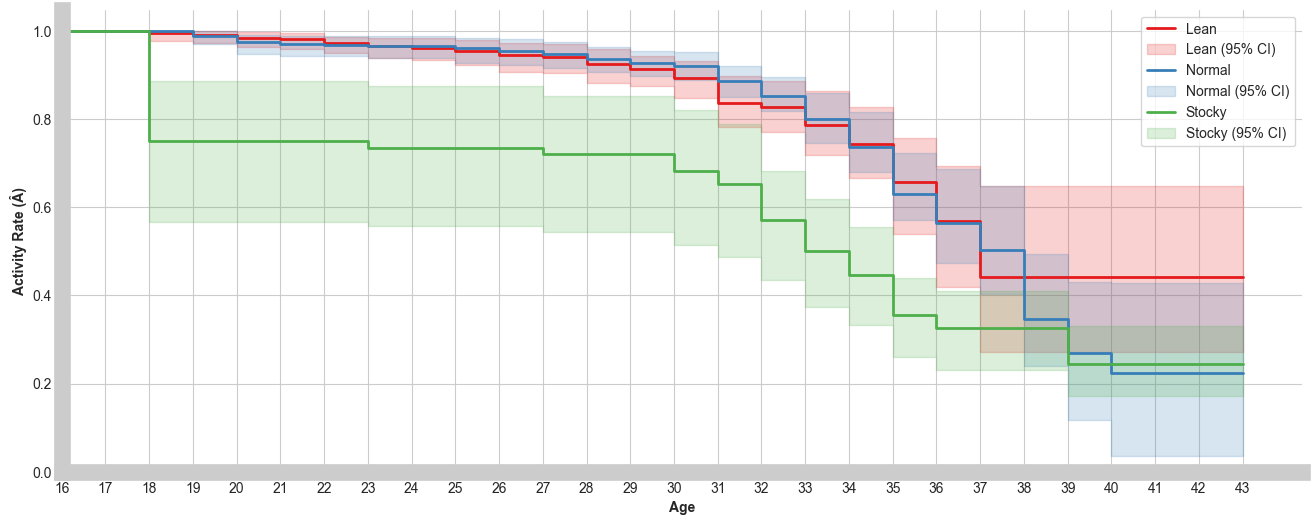

In [16]:
km_curves([body_type[k]["table"] for k in body_type], labels=[k for k in body_type], ci=True)

In [17]:
pairwise_log_rank_test([body_type[k]["table"] for k in body_type], labels=[k for k in body_type], n_tests=n_tests)

### 3 Comparisons | Corrected alpha: 0.0125 ###
Lean vs Normal -> Stat: 0.013865495515237879 - P-Value: 0.9062642911199789 - Not Rejected
Lean vs Stocky -> Stat: 2.3148124148433 - P-Value: 0.12814675905495898 - Not Rejected
Normal vs Stocky -> Stat: 3.225555689298307 - P-Value: 0.07249718741037403 - Not Rejected


#### Goalkeepers vs Field Players

In [18]:
# Filter the players by group and calculate their life tables
position = {
    "Goalkeeper": {
        "sample": players[players.position == "Goalkeeper"],
        "table": get_retire_table(players[players.position == "Goalkeeper"], age_range=range(players.age.min(), players.age.max()+1))
    },
    "FieldPlayer": {
        "sample": players[~(players.position == "Goalkeeper")],
        "table": get_retire_table(players[~(players.position == "Goalkeeper")], age_range=range(players.age.min(), players.age.max()+1)) 
    }
}
    

print("## SAMPLE SIZES PER GROUP ##")
for group in position:
    print(f"{group}: {len(position[group]['sample'])}")

## SAMPLE SIZES PER GROUP ##
Goalkeeper: 1167
FieldPlayer: 9992


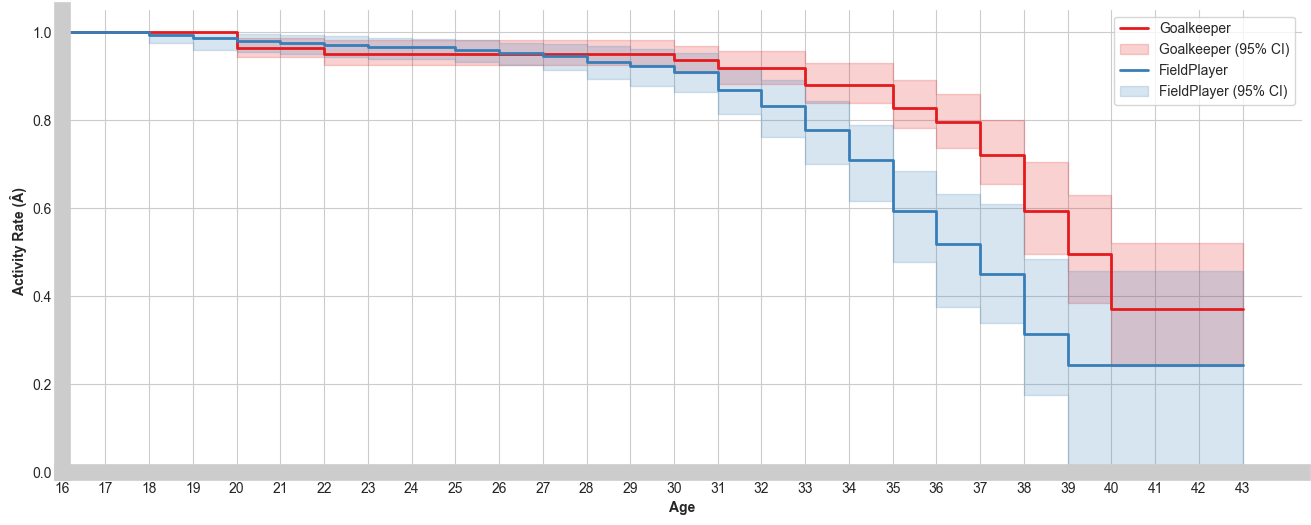

In [19]:
km_curves([position[k]["table"] for k in position], labels=[k for k in position], ci=True, color_palette="Set1")

In [20]:
pairwise_log_rank_test([position[k]["table"] for k in position], labels=[k for k in position], n_tests=n_tests)

### 1 Comparisons | Corrected alpha: 0.0125 ###
Goalkeeper vs FieldPlayer -> Stat: 7.357238673183522 - P-Value: 0.0066793292155507 - Rejected


## C. Prediction Models

In [21]:
# define columns for the model
feature_columns = [
    'age', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'skill_dribbling', 'skill_curve', 
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure'
]

# Selected models to tune
models_hyper = {
    "Lasso": {
        "model": Lasso(),
        "params": {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500], "Lasso__max_iter": [100000]},
    },
    "Ridge": {
        "model": Ridge(),
        "params": {'Ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100], "Ridge__max_iter": [100000]},
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(),
        "params": {"RandomForestRegressor__n_estimators" : [50, 100, 150], "RandomForestRegressor__max_depth": [10, None], 
                   "RandomForestRegressor__min_samples_split": [2, 5], "RandomForestRegressor__random_state": [seed]},
    }
}

### Data Preparation, Feature Standardization & Hyperparameter search

In [22]:
# extract features and target variable
X = players[feature_columns]
y = players['value_eur']

# handling missing values //// filling missing values in these feature columns by replacing them with the median of each column
X = X.fillna(X.median())
y = y.fillna(0)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

models = model_process(models_hyper, X_train, y_train, process=False, save_dir=MODELS+"age/", seed=seed)


Model: Lasso
BEST PARAMS: {'Lasso__alpha': 500}
RMSE: 6711370.192837903
MAE:3160547.4671818996
R2:0.4907801033558883

Model: Ridge
BEST PARAMS: {'Ridge__alpha': 100}
RMSE: 6719285.421708843
MAE:3146151.206944444
R2:0.48957827162751466

Model: RandomForestRegressor
BEST PARAMS: {'RandomForestRegressor__max_depth': None, 'RandomForestRegressor__min_samples_split': 5, 'RandomForestRegressor__n_estimators': 100, 'RandomForestRegressor__random_state': 7}
RMSE: 2658188.574606189
MAE:732401.8116263442
R2:0.9201169664322177


### Including Activity rate as predictor
We first use the non-discrimated "Remaining years" function as a predictor

In [23]:
# Use the estimator "e" (remaining years)
data = players.merge(professional_life_table[["age", "e"]], how="left", on="age")

if "age" in feature_columns:
    feature_columns.remove("age")
if "e" not in feature_columns:
    feature_columns.append("e")

# extract features and target variable
X = data[feature_columns]
y = data['value_eur']

# handling missing values: filling missing values in these feature columns by replacing them with the median of each column
X = X.fillna(X.median())
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

models_survival = model_process(models_hyper, X_train, y_train, process=process, save_dir=MODELS+"survival/", seed=seed)


Model: Lasso
BEST PARAMS: {'Lasso__alpha': 500}
RMSE: 7717591.506848622
MAE:3237294.6515456988
R2:0.45198811384614734

Model: Ridge
BEST PARAMS: {'Ridge__alpha': 100}
RMSE: 7737788.988805516
MAE:3232693.7789426525
R2:0.44911598887195725

Model: RandomForestRegressor
BEST PARAMS: {'RandomForestRegressor__max_depth': 10, 'RandomForestRegressor__min_samples_split': 2, 'RandomForestRegressor__n_estimators': 50, 'RandomForestRegressor__random_state': 7}
RMSE: 3643214.892441057
MAE:863636.0167114694
R2:0.8778774173479279


We now use the field player discrimated "Remaining years" function as a predictor

In [24]:
# Include a differential activity rate for goalkeepers and field players
goalkeepers = players[players.position == "Goalkeeper"]
field = players[~(players.position == "Goalkeeper")]

goalkeepers = goalkeepers.merge(position["Goalkeeper"]["table"][["age", "e"]], on="age", how="left")
field = field.merge(position["FieldPlayer"]["table"][["age", "e"]], on="age", how="left")

data = pd.concat([goalkeepers, field]).sort_values("player_id").reset_index(drop=True)

if "age" in feature_columns:
    feature_columns.remove("age")
if "e" not in feature_columns:
    feature_columns.append("e")
    
# extract features and target variable
X = data[feature_columns]
y = data['value_eur']

# handling missing values //// filling missing values in these feature columns by replacing them with the median of each column
X = X.fillna(X.median())
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

models_survival_discriminated = model_process(models_hyper, X_train, y_train, process=process, save_dir=MODELS+"survival_discriminated/", seed=seed)


Model: Lasso
BEST PARAMS: {'Lasso__alpha': 500}
RMSE: 6713699.348535927
MAE:3161109.335954301
R2:0.49042659633802477

Model: Ridge
BEST PARAMS: {'Ridge__alpha': 100}
RMSE: 6721560.880688356
MAE:3146536.633646953
R2:0.4892325085615402

Model: RandomForestRegressor
BEST PARAMS: {'RandomForestRegressor__max_depth': None, 'RandomForestRegressor__min_samples_split': 5, 'RandomForestRegressor__n_estimators': 100, 'RandomForestRegressor__random_state': 7}
RMSE: 2692864.5610971027
MAE:748439.1357526882
R2:0.9180192293108058


We test with both age and remaining years

In [25]:
# extract features and target variable
if "age" not in feature_columns:
    feature_columns.append("age")
if "e" not in feature_columns:
    feature_columns.append("e")

X = data[feature_columns]
y = data['value_eur']

# handling missing values: filling missing values in these feature columns by replacing them with the median of each column
X = X.fillna(X.median())
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

models_both = model_process(models_hyper, X_train, y_train, process=process, save_dir=MODELS+"both/", seed=seed)


Model: Lasso
BEST PARAMS: {'Lasso__alpha': 500, 'Lasso__max_iter': 100000}
RMSE: 6665196.439271216
MAE:3144510.956003584
R2:0.49776279417799896

Model: Ridge
BEST PARAMS: {'Ridge__alpha': 0.1, 'Ridge__max_iter': 100000}
RMSE: 6665222.473397213
MAE:3144959.6319892476
R2:0.49775887071307146

Model: RandomForestRegressor
BEST PARAMS: {'RandomForestRegressor__max_depth': None, 'RandomForestRegressor__min_samples_split': 5, 'RandomForestRegressor__n_estimators': 150, 'RandomForestRegressor__random_state': 7}
RMSE: 2633141.485390164
MAE:720389.386312724
R2:0.9216152882039976


Let's see how the best model predicts the on the test data

In [26]:
best_model = models_both["RandomForestRegressor"].model

actual_values = y_test
predicted_values_rf = best_model.predict(X_test)

print("RESULTS OF BEST MODEL ON TEST DATA")
print(f"RMSE: {np.sqrt(mean_squared_error(actual_values, predicted_values_rf))}")
print(f"MAE: {mean_squared_error(actual_values, predicted_values_rf)}")
print(f"R2: {r2_score(actual_values, predicted_values_rf)}")

RESULTS OF BEST MODEL ON TEST DATA
RMSE: 2184015.2314160736
MAE: 4769922531057.405
R2: 0.9445460348145611


In [27]:
test_players = players.loc[y_test.index]
test_players["predicted_value"] = predicted_values_rf
test_players["value_eur"] = test_players["value_eur"].fillna(0).astype(int)
test_players["predicted_value"] = test_players["predicted_value"].astype(int)
test_players["dif"] = abs(test_players["predicted_value"] - test_players["value_eur"])

test_players.to_csv(PROC_DATA + "test_set_predictions.csv", encoding="utf-8", index=False)

test_players[["player_id", "FIFA_long_name", "value_eur", "predicted_value", "dif"]].sort_values("dif")

,player_id,FIFA_long_name,value_eur,predicted_value
0,3875,Jermain Colin Defoe,400000,1273774
5,13283,Bram Castro,110000,4770112
8,16408,Orestis Spyridon Karnezis,350000,458159
11,22378,Leonardo de Matos Cruz,2100000,7471731
15,28947,Gonzalo Castro Randon,1900000,1122963
...,...,...,...,...
11140,241389,Indy Groothuizen,750000,488737
11141,255788,Cameron Robert Burgess,1200000,760783
11146,326329,Joris Kramer,750000,433030
11148,364245,Jordan Teze,8000000,477112


Let's plot the results from the test set

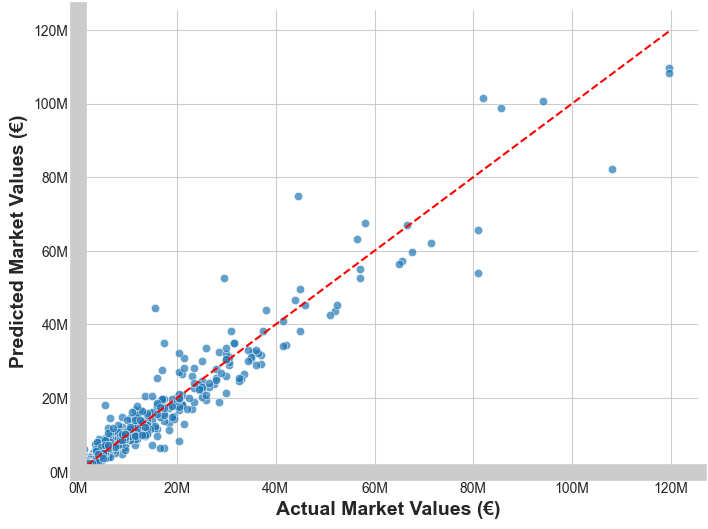

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=actual_values, y=predicted_values_rf, alpha=0.7, ax=ax)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.xlabel('Actual Market Values (€)', fontsize=14, weight="bold")
plt.ylabel('Predicted Market Values (€)', fontsize=14, weight="bold")
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim(0)
plt.xlim(0)
sns.despine(ax=ax, top=True, right=True)
plt.show()

Let's look at the importance of each feature

In [31]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=50, random_state=seed)

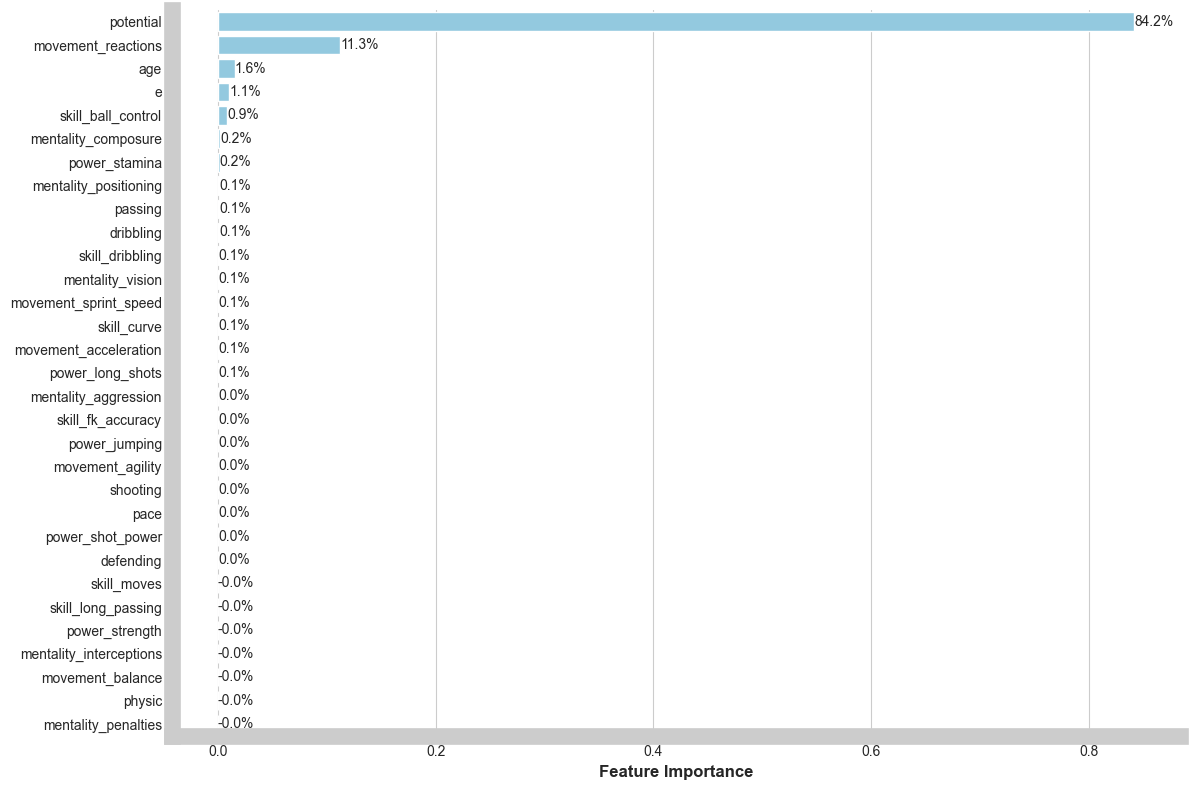

In [32]:
total_importance = result["importances_mean"].sum()

importances = [x / total_importance for x in result["importances_mean"]]
importances = np.array(importances)
sorted_idx = importances.argsort()[::-1]

fig, ax = plt.subplots(figsize=(12, 8))
bars = sns.barplot(y=np.array(feature_columns)[sorted_idx], x=importances[sorted_idx], color='skyblue', ax=ax)
plt.xlabel("Feature Importance", fontsize=12, weight="bold")

for bar in bars.patches:     
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.1%}', va='center', ha='left', fontsize=10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


plt.tight_layout()
sns.despine(top=True, right=True)
plt.show()

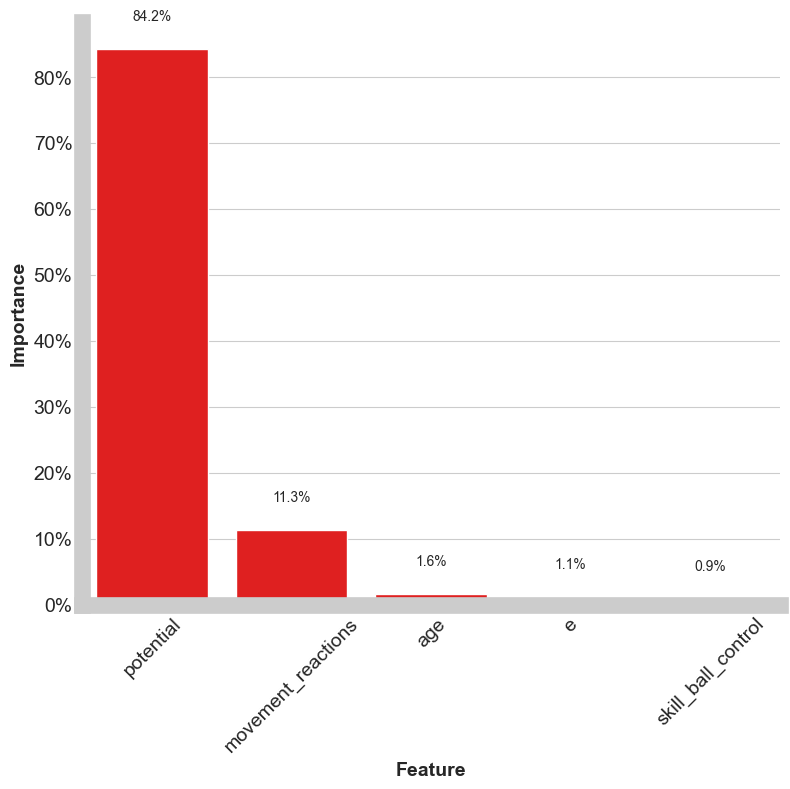

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
bars = sns.barplot(x=np.array(feature_columns)[sorted_idx][:5], y=importances[sorted_idx][:5], color='red', ax=ax)
plt.xlabel("Feature", fontsize=14, weight="bold")
plt.ylabel("Importance", fontsize=14, weight="bold")
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

for ix, bar in enumerate(bars.patches):  
    plt.text(ix, bar.get_height()+0.05, f'{bar.get_height():.1%}', va='center', ha='center', fontsize=10)

ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.tight_layout()
sns.despine(top=True, right=True)
plt.show()